# Solve Poisson's PDE
based on my soln for aero_ml repo

PDE is the following for $u(x_1, x_2) \in \mathcal{R}$:
$$ -\Delta u + u^3(x) = f(x), \quad \forall x \in \Omega $$
$$ u(x) = 0, \quad \forall x \in \partial \Omega $$

With forcing function chosen such that the true solution is:
$$ u(x_1, x_2) = sin(\pi x_1) sin(\pi x_2) + 4 sin(4 \pi x_1) sin(4 \pi x_2) $$

2024-12-05 19:14:16.973211: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733444056.984274  364381 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733444056.987852  364381 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 19:14:17.000497: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


type(x_train)=<class 'tensorflow.python.ops.resource_variable_ops.ResourceVariable'>


W0000 00:00:1733444058.365006  364381 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


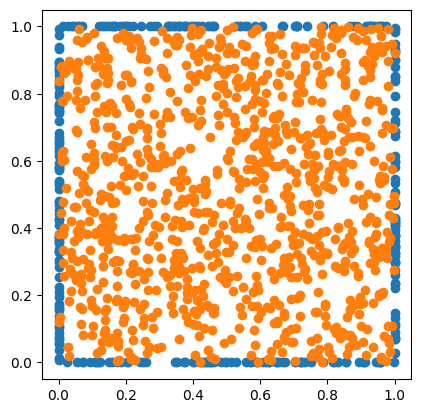

In [3]:
# define the domain
# -------------------
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# also see aero_ml demos

a, b = (1, 1)
num_domain, num_bndry, num_test = (1000, 300, 50)

# for debugging
# num_domain, num_bndry, num_test = (3, 2, 1)

num_interior = num_domain
DTYPE = tf.float64

# set the boundary of the panel
xmin = 0; xmax = a
ymin = 0; ymax = b

lb = tf.constant([xmin, ymin], dtype=DTYPE)
ub = tf.constant([xmax, ymax], dtype=DTYPE)

# generate the collocation points on the interior
def gen_collocation_points(num_domain, minval, maxval):
    x_r = tf.random.uniform((num_domain,1), minval[0], maxval[0], dtype=DTYPE)
    y_r = tf.random.uniform((num_domain,1), minval[1], maxval[1], dtype=DTYPE)
    X_r = tf.concat([x_r, y_r], axis=1)
    # data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
    # return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)
    return tf.Variable(X_r, dtype=DTYPE)

x_train = gen_collocation_points(num_domain, lb, ub)
x_test = gen_collocation_points(num_test, lb, ub)
print(f"{type(x_train)=}")

x = x_train[:,0:1]
y = x_train[:,1:2]

x2 = x_test[:,0:1]
y2 = x_test[:,1:2]

# generate boundary domain points
assert num_bndry % 2 == 0
N_b = int(num_bndry / 2)
x_b1 = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
y_b1 = lb[1] + (ub[1] - lb[1]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b1 = tf.concat([x_b1, y_b1], axis=1)

# boundary data on x edges
y_b2 = tf.random.uniform((N_b,1), lb[1], ub[1], dtype=DTYPE)
x_b2 = lb[0] + (ub[0] - lb[0]) * \
    tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
# print(f"{x_b2=}")
X_b2 = tf.concat([x_b2, y_b2], axis=1)
# print(f"{X_b2=}")
# print(f"{x_b2=}")

x_bndry = tf.Variable(tf.concat([X_b1, X_b2], axis=0), dtype=DTYPE)

# plot the data to check
plt.scatter(x_bndry[:,0], x_bndry[:,1])
plt.scatter(x_train[:,0], x_train[:,1]) # only show 1000 of the points
plt.gca().set_aspect('equal')
plt.show()

In [4]:
# define the kernel functions using tensorflow
# ------------------------------------------

L = 0.2

def kernel(x, xp):
    xbar = (x - xp) / L
    print(f"{xbar.shape=}")
    return tf.exp(-0.5 * tf.reduce_sum(tf.pow(xbar, 2.0), axis=-1))

def kernel_lapl(x, xp):
    xbar = tf.linalg.norm(x - xp, axis=-1)/L
    K = kernel(x, xp)
    return K * (xbar**2 - 2.0) / L**2

def kernel_lapl2(x, xp):
    xbar = tf.linalg.norm(x - xp, axis=-1)/L
    K = kernel(x, xp)
    return K * (xbar**4 - 8 * xbar**2 + 8) / L**4

In [5]:
# get the forcing terms to give the true solution
# use tensorflow to do autodiff

with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(x)
    tape2.watch(y)
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(x)
        tape1.watch(y)
        u_vals = tf.sin(np.pi * x) * tf.sin(np.pi * y) + \
            4.0 * tf.sin(4.0 * np.pi * x) * tf.sin(4.0 * np.pi * y)
        dx = tape1.gradient(u_vals, x)
        dy = tape1.gradient(u_vals, y)
    dx2 = tape2.gradient(dx, x)
    dy2 = tape2.gradient(dy, y)
    lapl = dx2 + dy2
u3 = tf.pow(u_vals, 3.0)
forces = (u3 - lapl).numpy()
# print(f"{forces=}")

In [6]:
# compare to forces from the other method
import sympy as sym
nI, nB = (num_interior, num_bndry)
N = 2 * nI + nB
# randomly generated interior points
# xI = np.random.rand(nI, 2)
xI = x_train.numpy()
xB = x_bndry.numpy()

# full set of points for linear operators
X = np.concatenate([xI, xB, xI], axis=0)
print(f"X shape = {X.shape}")

# get the forcing terms and forcing function
def ustar(x): # true solution
    x1 = x[0]; x2 = x[1]
    return np.sin(np.pi * x1) * np.sin(np.pi * x2) + 4 * np.sin(4 * np.pi * x1) * np.sin(4 * np.pi * x2)
x_sym = [sym.Symbol(f"x{i}") for i in range(2)]
x1 = x_sym[0]; x2 = x_sym[1]
ustar_sym = sym.sin(np.pi * x1) * sym.sin(np.pi * x2) + 4 * sym.sin(4 * np.pi * x1) * sym.sin(4 * np.pi * x2)
f_sym = sum([sym.diff(ustar_sym, x_sym[i], 2) for i in range(2)]) + ustar_sym**3

# true solution at each point
u_truth = np.array([ustar(X[i,:]) for i in range(N)])

def force(x):
    # use symbolic manipulation to get the force from the true solution
    # alternative might be to use complex-step method
    x1 = x[0]; x2 = x[1]
    return f_sym.subs(x_sym[0], x1).subs(x_sym[1], x2)

F_int = np.array([float(force(xI[i,:])) for i in range(nI)])

print(f"{forces[:10,0]}")
print(f"{F_int[:10]=}")

X shape = (2300, 2)
[ -601.07251032   -90.72745365  1119.76054948  -634.22193387
  1230.57235956 -1159.79321277  -737.31623685  1107.79435106
    49.72013045  -866.23099623]
F_int[:10]=array([  598.97459138,    91.23132476,  -979.44819771,   627.37930819,
       -1117.65722022,  1079.4385412 ,   728.50187552, -1000.3641057 ,
         -48.78074398,   843.23067513])


xbar.shape=TensorShape([1300, 1300, 2])
xbar.shape=TensorShape([1300, 1000, 2])
xbar.shape=TensorShape([1000, 1000, 2])
Kblock_prereg.shape=TensorShape([2300, 2300])
RegMat.shape=TensorShape([2300, 2300])


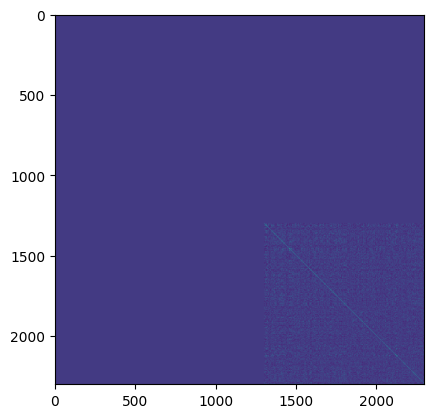

In [7]:
# build the covariance matrix
# ---------------------------

num_all = num_interior + num_bndry
num_block = 2 * num_interior + num_bndry
x_all = tf.concat([x_train, x_bndry], axis=0)
x_all_L = tf.expand_dims(x_all, axis=1)
x_all_R = tf.expand_dims(x_all, axis=0)
K11 = tf.constant(kernel(x_all_L, x_all_R), dtype=DTYPE)

x_interior_L = tf.expand_dims(x_train, axis=1)
x_interior_R = tf.expand_dims(x_train, axis=0)
K12 = tf.constant(kernel_lapl(x_all_L, x_interior_R), dtype=DTYPE)
K22 = tf.constant(kernel_lapl2(x_interior_L, x_interior_R), dtype=DTYPE)

_row1 = tf.constant(tf.concat([K11, K12], axis=1))
_row2 = tf.constant(tf.concat([tf.transpose(K12), K22], axis=1))
Kblock_prereg = tf.concat([_row1, _row2], axis=0)
print(f"{Kblock_prereg.shape=}")

# add regularization matrix with trace ratios used to scale each diagonal block
tr11 = tf.linalg.trace(K11)
tr22 = tf.linalg.trace(K22)
Rvec = np.concatenate([np.ones(num_all,), tr22/tr11*np.ones(num_interior,)]).astype(np.float64)
RegMat = tf.linalg.diag(Rvec)
print(f"{RegMat.shape=}")

Kblock = Kblock_prereg + 1e-5 * RegMat
Kblock = Kblock.numpy()
plt.imshow(Kblock)

In [8]:
# # compare to other kenrnel matrix
# # construct cost matrix K(phi,phi) = Kpp and K(X,phi) = Kxp matrix
# import time
# G_sigma = 0.2
# eta = 1e-5
# print("Building K(x,phi) and K(phi,phi) matrices...")
# start_Theta = time.time()
# def kernel(xm, xl, sigma=1, order=0):
#     D = xm.shape[0]
#     norm_sq = np.dot(xm-xl, xm-xl)
#     if order == 0: # regular function
#         return np.exp(-norm_sq/2.0/sigma**2)
#     elif order == 1: # first Laplacian
#         K = kernel(xm,xl,sigma=sigma, order=0)
#         return 1 * K * (norm_sq - D * sigma**2) / sigma**4
#     elif order == 2:
#         K = kernel(xm,xl,sigma=sigma, order=0)
#         return K * (norm_sq**2 - 2 * (2 + D) * norm_sq * sigma**2 + D * (2 + D) * sigma**4) / sigma**8

# X = np.concatenate([x_train.numpy(), x_bndry.numpy(), x_train.numpy()], axis=0)

# Kpp = np.zeros((N,N))
# Kxp = np.zeros((N,N))
# for m in range(N):
#     xm = X[m,:]
#     m_2nd = m >= nB + nI # last group of pts, boolean for 2nd order operator
#     for l in range(N):
#         xl = X[l,:]
#         l_2nd = l >= nB + nI
#         deriv_order = 1.0 * (m_2nd + l_2nd)
#         # double check the sign stuff here
#         sgn1 = 1.0 if deriv_order == 1.0 else 1.0
#         sgn2 = 1.0 if l_2nd else 1.0
#         Kpp[m,l] = sgn1 * kernel(xm,xl,sigma=G_sigma, order=deriv_order)
#         Kxp[m,l] = sgn2 * kernel(xm,xl,sigma=G_sigma, order=1.0 * l_2nd)

# # add nugget to Kpp to improve condition number otherwise Kpp
# # has det(Kpp) = 0 and the Gauss-Newton iterations do not converge (see Appendix A.1 in Y. Chen's paper)
# # here I add the matrix eta * R to Kpp where R is an adaptive block-diagonal version of I
# # since the omag of each block-diagonal section is different
# trace11 = np.trace(Kpp[:nI, :nI])
# trace22 = np.trace(Kpp[nI:nI+nB, nI:nI+nB])
# trace33 = np.trace(Kpp[nI+nB:, nI+nB:])
# Rvec = np.concatenate([
#     np.ones((nI,)),
#     (trace22/trace11) * np.ones((nB,)),
#     (trace33/trace11) * np.ones((nI,))
# ])
# R = np.diag(Rvec) # block-diagonal scaled nugget matrix
# Kpp += eta * R


# rel_err_Kpp = np.log(1e-16 + np.abs((Kpp - Kblock) / Kpp))
# # print(f"{rel_err_Kpp}")
# plt.imshow(rel_err_Kpp)
# plt.colorbar()

# # Kdiff = Kpp - Kblock
# # plt.imshow(Kdiff)

In [9]:
# just do tensorflow optimization now
# K_lu = tf.linalg.lu(Kblock)
w_ext = tf.zeros(shape=(num_bndry,1), dtype=DTYPE)

theta_arr = tf.zeros(shape=(num_domain,1), dtype=DTYPE)
# theta = tf.Variable(theta_arr, trainable=True, dtype=DTYPE)
theta = theta_arr.numpy()

In [10]:
learning_rate = 1e-5 # can be much higher here?
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [11]:
use_newton = True

if use_newton:
# -----------------------------------------

    for inewton in range(12):
        # matrix is dimensions num_interior x num_block
        dzdth = np.concatenate([
            np.eye(num_interior), np.zeros((num_interior,num_bndry)),
            np.diag(3*theta[:,0]**2)
        ], axis=-1)
        
        # get actual value of z as in nMAP = z^T * Cov^-1 * z
        # theta = theta[:1,:]
        # forces = forces[:1,:]
        z = np.concatenate([
            theta, np.zeros((num_bndry,1)), theta**3 - forces
        ], axis=0)
        # print(f"{z=}")

        # H * dth = -grad is newton update
        temp = np.linalg.solve(Kblock, dzdth.T)
        H = 2 * dzdth @ temp

        temp2 = np.linalg.solve(Kblock, z)
        grad = 2 * dzdth @ temp2

        # newton update
        dtheta = -np.linalg.solve(H, grad)
        # print(f"{dtheta.shape=} {theta.shape=}")
        # theta.assign(theta + dtheta)
        alpha = 1.0
        theta = theta + alpha * dtheta

        # new objective cost
        newz = np.concatenate([
            theta, np.zeros((num_bndry,1)), theta**3 - forces
        ], axis=0)
        temp3 = np.linalg.solve(Kblock, newz)
        loss = newz.T @ temp3
        print(f"{inewton=} {loss=}")


inewton=0 loss=array([[3508682.46485339]])
inewton=1 loss=array([[36377.80033764]])
inewton=2 loss=array([[24809.2225357]])
inewton=3 loss=array([[24809.04405119]])
inewton=4 loss=array([[24809.04405117]])
inewton=5 loss=array([[24809.04405117]])
inewton=6 loss=array([[24809.04405117]])
inewton=7 loss=array([[24809.04405117]])
inewton=8 loss=array([[24809.04405117]])
inewton=9 loss=array([[24809.04405117]])
inewton=10 loss=array([[24809.04405117]])
inewton=11 loss=array([[24809.04405117]])


In [12]:
# # Kpp_inv = np.linalg.inv(Kblock)
# Kpp_inv = np.linalg.inv(Kpp)

# nI, nB = (num_interior, num_bndry)
# w = np.zeros((nI,))

# # useful functions
# def z_func(w):
#     z = np.concatenate([w, np.zeros((nB,)), F_int - w**3], axis=0)
#     return np.reshape(z, newshape=(2*nI + nB,1))

# def cost_func(w):
#     z = z_func(w)
#     return z.T @ Kpp_inv @ z

# for inewton in range(12):
#     z = z_func(w)
#     icost = cost_func(w)
    
#     # Jacobian matrix J_ij = dzj/dwi = nabla_w z has dimension R^{s(w) x s(z)}
#     dz_dw = np.concatenate([np.eye(nI), np.zeros((nI, nB)), -np.diag(3*w**2)], axis=-1)

#     # Newton's iteration update dw = - Hinv * grad of objective
#     # with matrix H = dz_dw * Kpp^-1 * dz_dw^T in R^(s(w) x s(w))
#     H = 2 * dz_dw @ Kpp_inv @ dz_dw.T
#     # gradient of objective is grad = dz_dw * Kpp_inv * z in R^(s(w) x 1)
#     grad = 2 * dz_dw @ Kpp_inv @ z

#     # perform the Newton's update on w
#     dw = - np.linalg.solve(H, grad)

#     # compute the new objective cost
#     newz = z + dz_dw.T @ dw
#     cost = newz.T @ Kpp_inv @ newz
#     print(f"cost_{inewton} = {float(cost):.4e}")

#     # unity learning rate
#     w += dw[:,0]

In [13]:
if not use_newton:
# ----------------------------------------
    # tensorflow adam optimizer method
    num_epochs = 1000

    for epoch in range(num_epochs):
        # record the loss gradient
        with tf.GradientTape(persistent=True) as tape:
            z = tf.concat([theta, w_ext, tf.pow(theta, 3.0) - forces], axis=0) * 1e6
            ans = tf.linalg.lu_solve(*K_lu, rhs=z)

            loss = tf.matmul(z, ans, transpose_a=True)

        loss_gradient = tape.gradient(loss, theta)
        # print(f"{loss_gradient=}")

        # could change to Gauss-newton algorithm here instead.. would prob be better

        # gradient descent with adam optimizer
        optimizer.apply_gradients(
            [(loss_gradient, theta)]
        )
        del tape

        loss_val = loss.numpy()[0,0]
        print(f"{epoch=}\t{loss_val=}")

In [14]:
# # plot solution against true solution
# z = np.concatenate([w, np.zeros((nB,)), F_int - w**3], axis=0)
# z = np.reshape(z, newshape=(N,1))

# # compute the solution vector u = Kxp * Kpp^-1 * z
# u = Kxp @ Kpp_inv @ z
# u = np.reshape(u, newshape=(N,))

# # print(f"{u=}")

# # dt_newtons = time.time() - start_newton
# # print(f"finished newton's iteration in {dt_newtons} sec.")

# # DONE with NEWTON'S METHOD
# # ------------------------------------------------------------------------

# # PLOT AND REPORT SOLUTION
# # -------------------------------------------------------------------------
# plt.figure("nonlinear-poissons")
# plt.scatter(X[:,0], X[:,1], c=u)
# ax = plt.gca()
# plt.title("approximate solution u")
# ax.set_aspect('equal', adjustable='box')
# plt.show()
# plt.close("nonlinear-poissons")

# # compute the solution residuals and plot them
# uresid = u - u_truth
# resid_norm = np.max(np.abs(uresid))
# rel_resid_norm = resid_norm / np.max(np.abs(u_truth))
# print(f"u residual norm = {rel_resid_norm:.4e}")

# # plot the u solution error
# plt.figure("nonlinear-poissons-error")
# plt.scatter(X[:,0], X[:,1], c=uresid)
# plt.title("error in solution u")
# ax = plt.gca()
# ax.set_aspect('equal', adjustable='box')
# plt.show()
# plt.close("nonlinear-poissons-error")


In [15]:
# predict the values at a grid of points (a mesh) so we can view predicted contour of the solution
# using the mean interpolated from trained values
import numpy as np

n = 100
ngrid = n * n
_xgrid = np.linspace(0.0, a, n)
_ygrid = np.linspace(0.0, b, n)
Xgrid, Ygrid = np.meshgrid(_xgrid, _ygrid)
xgrid = np.reshape(Xgrid, newshape=(ngrid,1))
ygrid = np.reshape(Ygrid, newshape=(ngrid,1))
x_grid = np.concatenate([xgrid, ygrid], axis=1)

# old non-vectorized way
# K_train = np.array([[kernel2d(x_all[i,:], x_all[j,:]) for j in range(num_all)] for i in range(num_all)])
# K_cross = np.array([[kernel2d(x_grid[i,:], x_all[j,:]) for j in range(num_all)] for i in range(ngrid)])

# vectorized way like 100x faster
K_train = kernel(x_all_L, x_all_R)
x_grid_L = tf.expand_dims(tf.constant(x_grid, dtype=DTYPE), axis=1)
K_cross = kernel(x_grid_L, x_all_R)

max_eigval = np.max(np.linalg.eigvalsh(K_train))
W_grid = K_cross @ np.linalg.solve(K_train + 1e-5 * max_eigval * np.eye(num_all), z[:num_all,:])
W = np.reshape(W_grid, newshape=(n, n))

xbar.shape=TensorShape([1300, 1300, 2])
xbar.shape=TensorShape([10000, 1300, 2])


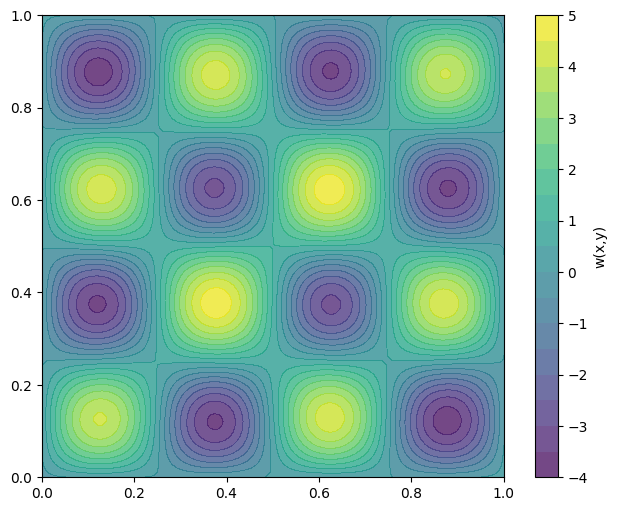

In [16]:
import matplotlib.pyplot as plt
# now plot the predicted solution contour
plt.figure(figsize=(8, 6))
colors = plt.contourf(Xgrid, Ygrid, W, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="w(x,y)")  # Colorbar for reference

/tmp/ipykernel_364381/1189284440.py:4: RuntimeWarning: divide by zero encountered in divide
  W_rel_err = np.log(1e-16 + abs((W - W_true) / W_true))


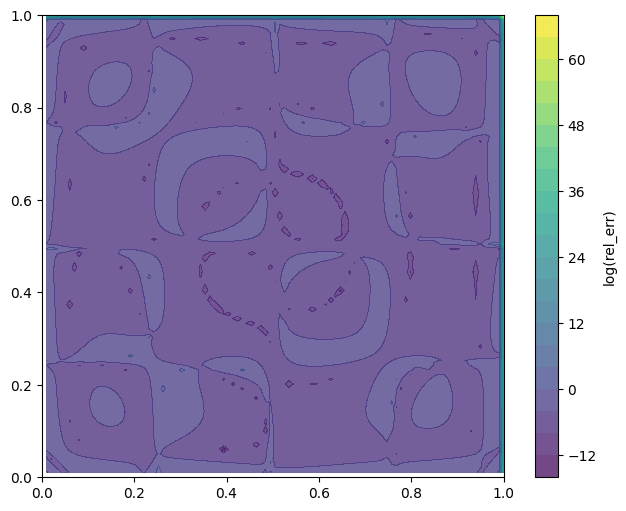

In [21]:
# relative error against true solution
import numpy as np
W_true = np.sin(np.pi * Xgrid) * np.sin(np.pi * Ygrid) + 4.0 * np.sin(4.0 * np.pi * Xgrid) * np.sin(4.0 * np.pi * Ygrid)
W_rel_err = np.log(1e-16 + abs((W - W_true) / W_true))

plt.figure(figsize=(8, 6))
colors = plt.contourf(Xgrid, Ygrid, W_rel_err, levels=20, cmap='viridis', alpha=0.75)  # Filled contours
plt.gca().set_aspect('equal')
plt.colorbar(colors, label="log(rel_err)")  # Colorbar for reference